In [1]:
import torch, time, copy
import torch.nn as nn
import torch.optim as optim
from torch.quantization import prepare, convert
from src.utils import *
from src.override_resnet import *
import matplotlib.pyplot as plt


In [2]:
device = "cuda"
model = resnet50(weights=resnet.ResNet50_Weights.DEFAULT)
model.to(device)
model.eval()

# set fuse ############################################################
model = fuse_ALL(model)

model.fc.qconfig = torch.quantization.QConfig(
    activation=torch.quantization.RecordingObserver.with_args(dtype=torch.qint8),
    weight=None,
)


# for name, module in model.named_modules():
#     # print(name)
#     # if hasattr(module, "qconfig"):
#     #     if module.qconfig is not None:
#     #         print(f"{name} | {module.qconfig}")
#     if len(name) > 2 and name[-4:] == "relu":
#         print(f"{name} | ")
#         module.qconfig = torch.quantization.QConfig(
#             activation=torch.quantization.RecordingObserver.with_args(dtype=torch.qint8),
#             weight=None,
#         )

prepare(model, inplace=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:

# calibrate the model ############################################################
criterion = nn.CrossEntropyLoss()
batch_size = 25
train_loader, _ = GetDataset(
    dataset_name="ImageNet",
    device=device,
    root="data",
    batch_size=batch_size,
    num_workers=8,
)

limit = int(1000 / batch_size)
with torch.no_grad():
    for images, _ in tqdm.tqdm(train_loader):
        images = images.to(device)
        _ = model(images)

        limit -= 1
        if limit == 0:
            break

  0%|          | 39/51247 [00:01<34:28, 24.76it/s]  


In [4]:
dja = model.fc.activation_post_process.get_tensor_value()
print(len(dja))
print(len(dja[0]))
print(len(dja[0][0]))
# print(len(dja[0][0][0])) // Not exist
# Assuming 'dja' is a list containing PyTorch tensors
dja = [tensor.to("cpu") for tensor in dja]
dja = torch.cat(dja).flatten()
print(dja.shape)

40
25
1000
torch.Size([1000000])


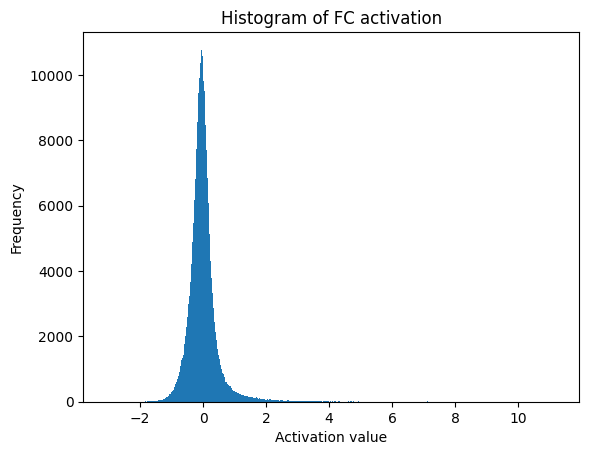

In [5]:
plt.hist(dja, bins=2048)
plt.title("Histogram of FC activation")
plt.xlabel("Activation value")
plt.ylabel("Frequency")
plt.show()

5 * 32 * 1000 * 50 * 32 / 4 = 6.4GB